In [ ]:
# CSE 674 Project 3: Super Resolution GAN
# Name : Mitul Modi
# UB Person No : 50288649
# email : mitulraj@buffalo.edu

In [ ]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models 
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image as I
from PIL import Image
import time
import math
from torchvision.models.vgg import vgg19
from torchcontrib.optim import SWA
from tqdm import tnrange, tqdm_notebook
from math import exp
import torch.nn.functional as F
from torch.autograd import Variable
from math import log10

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Utility Functions and classes

In [ ]:
# Pytorch doesn't have in built function to calculate Structural SIMilarity(SSIM) between two images.
# This blovk implements SSIM 
# Code Reference - https://github.com/Po-Hsun-Su/pytorch-ssim
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)    

In [ ]:
def get_psnr(i_sr, i_hr):
    """Function to calculate Peak Signal to Noise Ratio (PSNR) for pair of images"""
    mse = F.mse_loss(i_sr, i_hr)
    psnr = 10 * log10(1 / mse.item())
    return psnr

In [ ]:
def save_model(filename, model, optimizer, scheduler, epoch, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist, early_stop_counter):
    """
        Function to save model.
        
        Function saves model and other training related information so that it can be loaded later to resume training or for inference.
        It is called by fit() function to save best model during training.
    """
    state_dict = {
        'epoch':epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict() if scheduler is not None else '',
        'loss_tr_hist': loss_tr_hist,
        'loss_val_hist': loss_val_hist,
        'accuracy_tr_hist': accuracy_tr_hist,
        'accuracy_val_hist': accuracy_val_hist,
        'early_stop_counter': early_stop_counter
    }
    torch.save(state_dict, filename)

In [ ]:
def load_model(filename, model, optimizer = None, scheduler = None, mode = 'test'):
    """
        This function loads previously saved model and its related training details from file specified by filename.
        
        Parameters:
            filename : path of saved model file.
            model : Instance of model to be loaded.
            optimizer : Instance of optimizer to be loaded to previous saved state. Useful to resume training of model from saved state.
            scheduler : Instance of scheduler to be loaded to previous saved state. Useful to resume training of model from saved state.
            mode : Values should be 'train' or 'test'. If value is 'train', it returns model and all other information required to resume training from saved state.
                   If value is 'test', it loads and returns only model.
    """
    state_dict = torch.load(filename, map_location=lambda storage, loc: storage)

    model.load_state_dict(state_dict['model'])
    if mode == 'test':
        return model

    epoch = state_dict['epoch']
    optimizer.load_state_dict(state_dict['optimizer'])
    loss_tr_hist = state_dict['loss_tr_hist']
    loss_val_hist = state_dict['loss_val_hist']
    accuracy_tr_hist = state_dict['accuracy_tr_hist']
    accuracy_val_hist = state_dict['accuracy_val_hist']
    early_stop_counter = state_dict['early_stop_counter']
    if scheduler is not None:
        scheduler.load_state_dict(state_dict['scheduler'])

    return epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist

In [ ]:
def train(dataloader, model_d, model_g, optimizer_d, optimizer_g, criterion_d, criterion_g, steps_per_epoch):
    """
        Function to perform training step.
        
        This function performs primary step of training. It performs forward and backward pass to update model parameters. It is called by fit() function during each epoch. 
        Returns loss and accuracy for current epoch.
    """
    batch = 0
    loss_d = 0.0
    loss_g = 0.0
    content_loss = 0.0
    adversarial_loss = 0.0
    ssim_tr = 0.0

    model_d.train()
    model_g.train()
    for step, (i_lr, i_hr) in enumerate(dataloader):

        # Prepare Low Resolution (real downsampled), High Resolution (real) and Super Resolution (fake) Images
        i_lr = i_lr.to(device, non_blocking=False)
        i_hr = i_hr.to(device, non_blocking=False)
        i_sr = model_g(i_lr)

        # Prepare labels for high resolution (real) and super resolution (fake) images.
        batch_size = i_hr.size(0)        
        label_hr = torch.full((batch_size,1), 1, device=device)
        label_sr = torch.full((batch_size,1), 0, device=device)

        # Clear Gradients of both generator and descriminator models
        model_d.zero_grad()        
        model_g.zero_grad() 

        # Calculate discriminator loss and gradients for high resolution (real) images
        logits_d_hr = model_d(i_hr)
        if DEBUG:
            print("Discriminator Logits (Real Pass):", logits_d_hr)
        cur_loss_d_hr = criterion_d(logits_d_hr, label_hr)
        cur_loss_d_hr.backward()

        # Calculate discriminator loss and gradients for super resolution (fake) images
        logits_d_sr = model_d(i_sr)
        if DEBUG:
            print("Discriminator Logits (Fake Pass):", logits_d_sr)
        cur_loss_d_sr = criterion_d(logits_d_sr, label_sr)       
        cur_loss_d_sr.backward()
        
        cur_loss_d = cur_loss_d_hr + cur_loss_d_sr
        # Update Descriminator
        optimizer_d.step()
        loss_d += cur_loss_d.item()
        
        # Get logits from updated discriminator and calculate perceptual loss and gradients for generator
        i_sr = model_g(i_lr)
        logits_d_sr = model_d(i_sr)
        if DEBUG:
            print("Discriminator Logits (Generator Pass):", logits_d_sr)
        cur_content_loss, cur_adversarial_loss, perceptual_loss = criterion_g(i_sr, i_hr, logits_d_sr, label_hr)
        cur_loss_g = perceptual_loss
        torch.cuda.empty_cache()
        cur_loss_g.backward()
        # Update Generator
        optimizer_g.step()

        loss_g += cur_loss_g.item()
        content_loss += cur_content_loss.item()
        adversarial_loss += cur_adversarial_loss.item()
        # Display Progres Bar. 
        # Reference - https://stackoverflow.com/questions/46141302/how-to-make-a-still-progress-in-python/46141777
        batch += 1
        completed = math.floor(step / steps_per_epoch * 50)
        print('\r' + 'Training: ' + '▮' * completed + '▯' * (50-completed) + str(completed*2) + '%', end='')
        
        if step == steps_per_epoch:
            break
    
    print('\r', end='')
    
    loss_d /= float(steps_per_epoch * dataloader.batch_size)
    loss_g /= float(steps_per_epoch * dataloader.batch_size)
    content_loss /= float(steps_per_epoch * dataloader.batch_size)
    adversarial_loss /= float(steps_per_epoch * dataloader.batch_size)
    #ssim_tr /= float(steps_per_epoch)
    return loss_d, loss_g, content_loss, adversarial_loss#, ssim_tr

In [ ]:
def validate(dataloader, model_d, model_g, criterion_d, criterion_g):
    """
        Function to perform validation step.
        
        This function is used to perform validation of a model. It is called by function fit() during each epoch.
        Returns validation loss and accuracy for current epoch.
    """

    batch = 0    
    loss_d = 0.0
    loss_g = 0.0
    content_loss = 0.0
    adversarial_loss = 0.0

    model_d.eval()
    model_g.eval()
    with torch.no_grad():
        for i_lr, i_hr in dataloader:
            
            # Prepare Low Resolution (real downsampled), High Resolution (real) and Super Resolution (fake) Images            
            i_lr = i_lr.to(device, non_blocking=False)
            i_hr = i_hr.to(device, non_blocking=False)
            i_sr = model_g(i_lr)
            
            # Prepare labels for high resolution (real) and super resolution (fake) images.            
            batch_size = i_hr.size(0)    
            label_hr = torch.full((batch_size,1), 1, device=device)
            label_sr = torch.full((batch_size,1), 0, device=device)

            
            logits_d_hr = model_d(i_hr)
            cur_loss_d_hr = criterion_d(logits_d_hr, label_hr)                           

            logits_d_sr = model_d(i_sr)
            cur_loss_d_sr = criterion_d(logits_d_sr, label_sr)
            
            cur_loss_d = cur_loss_d_hr + cur_loss_d_sr
            loss_d += cur_loss_d.item()
        
            cur_content_loss, cur_adversarial_loss, perceptual_loss  = criterion_g(i_sr, i_hr, logits_d_sr, label_hr)
            cur_loss_g = perceptual_loss
            loss_g += cur_loss_g.item()

            content_loss += cur_content_loss.item()
            adversarial_loss += cur_adversarial_loss.item()
            
            # Display Progres Bar. 
            # Reference - https://stackoverflow.com/questions/46141302/how-to-make-a-still-progress-in-python/46141777        
            batch += 1
            completed = math.floor(batch * dataloader.batch_size / len(dataloader.dataset) * 50)
            print('\r' + 'Validation: ' + '▮' * completed + '▯' * (50-completed) + str(completed*2) + '%', end='')
    
    print('\r', end='')        
        
    loss_d = loss_d / float(len(dataloader.dataset))
    loss_g = loss_g / float(len(dataloader.dataset))
    content_loss = content_loss / float(len(dataloader.dataset))
    adversarial_loss = adversarial_loss / float(len(dataloader.dataset))

    return loss_d, loss_g, content_loss, adversarial_loss

In [ ]:
def fit(dataloader_tr, dataloader_val, model_d, model_g, criterion_d, criterion_g, optimizer_d, optimizer_g, max_epoch = 100, steps_per_epoch = 50, scheduler_d = None, scheduler_g = None, filename = None, early_stop = True, patience = 10, resume = False):
    """
        Function to train and validate model for given epochs. It calls train and validate functions.
        
        Parameters: 
            dataloader_tr : data loader for training dataset.
            dataloader_val : dataloader for validation dataset.
            model : Instance of a Model. which is to be trained.
            criterion : criterion or loss function
            optimizer : Instance of Optimizer.
            max_epoch : Maximum number of epochs to train model
            steps_per_epoch : Number of batches to train per epoch
            scheduler : learning rate scheduler to change value of learning rate while model is trained.
            filename : Filename to save the best model during training. Function will save model with lowest validation loss, so that best model can be retrieved after training.
                       If resume = True, filename will be used to load previously saved model and resume the training.
            early_stop : If True, training will be stopped when validation_loss doesnt improve for epochs specified by patience. Recommended to prevent overfitting.
            patience : number of epochs to wait for early_stopping.
            resume : If True, model specified by filename will be loaded and training will be resumed for loaded model.
        Returns history of Training and Validation loss for Generator and Discriminator models.
    """
    start_epoch = 0
    early_stop_counter = 0
    min_loss_val_d = 1e10    
    loss_tr_hist_d = []
    loss_val_hist_d = []
    accuracy_tr_hist_d = []
    accuracy_val_hist_d = []
    min_loss_val_g = 1e10    
    loss_tr_hist_g = []
    loss_val_hist_g = []
    accuracy_tr_hist_g = []
    accuracy_val_hist_g = []
    
    
    if filename is not None:
        filename_d = "{0}_{2}{1}".format(*os.path.splitext(filename) + tuple('d'))
        filename_g = "{0}_{2}{1}".format(*os.path.splitext(filename) + tuple('g'))
    
    if resume == True:
        assert filename is not None
        
        start_epoch, model_d, optimizer_d, scheduler_d, early_stop_counter, loss_tr_hist_d, loss_val_hist_d, accuracy_tr_hist_d, accuracy_val_hist_d = load_model(filename_d, model_d, optimizer_d, scheduler_d, mode = 'train')
        start_epoch, model_g, optimizer_g, scheduler_g, early_stop_counter, loss_tr_hist_g, loss_val_hist_g, accuracy_tr_hist_g, accuracy_val_hist_g = load_model(filename_g, model_g, optimizer_g, scheduler_g, mode = 'train')
        
    for epoch in range(start_epoch+1, max_epoch + 1):
        t0 = time.time()

        loss_tr_d, loss_tr_g, content_loss_tr, adversarial_loss_tr = train(dataloader_tr, model_d, model_g, optimizer_d, optimizer_g, criterion_d, criterion_g, steps_per_epoch)
        loss_tr_hist_d.append(loss_tr_d)
        loss_tr_hist_g.append(loss_tr_g)

        if dataloader_val is not None:
            optimizer_d.swap_swa_sgd()
            optimizer_g.swap_swa_sgd()
            loss_val_d, loss_val_g, content_loss_val, adversarial_loss_val = validate(dataloader_val, model_d, model_g, criterion_d, criterion_g)
            loss_val_hist_d.append(loss_val_d)
            loss_val_hist_g.append(loss_val_g)

        if scheduler_d is not None:
            scheduler_d.step(loss_val_d)

        if scheduler_g is not None:
            scheduler_g.step(loss_val_g)
        
        # Save model weights at every 5 epochs.
        if filename is not None:
            if epoch % 5 == 0:
                save_model(filename_g, model_g, optimizer_g, scheduler_g, epoch, loss_tr_hist_g, loss_val_hist_g, None, None, early_stop_counter)
                save_model(filename_d, model_d, optimizer_d, scheduler_d, epoch, loss_tr_hist_d, loss_val_hist_d, None, None, early_stop_counter)

        if dataloader_val is not None:
            print("[{0:3d} / {1:3d}]  |  Loss_Tr_d: {2:10.7f}  |  Loss_Tr_g: {3:10.7f}/{4:10.7f}/{5:10.7f}  |  Loss_Val_d: {6:10.7f}  |  Loss_Val_g: {7:10.7f}/{8:10.7f}/{9:10.7f}  |  Time taken: {10:7.4f}s".format(epoch, max_epoch, loss_tr_d, loss_tr_g, content_loss_tr, adversarial_loss_tr, loss_val_d, loss_val_g, content_loss_val, adversarial_loss_val, time.time() - t0))
        else:
            print("[{0:3d} / {1:3d}]  |  Loss_Tr_d: {2:10.7f}  |  Loss_Tr_g: {3:10.7f}/{4:10.7f}/{5:10.7f}  |  Time taken: {6:7.4f}s".format(epoch, max_epoch, loss_tr_d, loss_tr_g, content_loss_tr, adversarial_loss_tr, time.time() - t0)) 
        
        if early_stop == True and early_stop_counter > patience:
            print('\nEarly Stopping ... !')
            break

    return loss_tr_hist_d, loss_val_hist_d, loss_tr_hist_g, loss_val_hist_g

In [ ]:
def init_weights(module):
    """ Function to initialze weights using Kaiming Uniform method"""
    if isinstance(module, nn.Conv2d):
        init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
    if isinstance(module, nn.Linear):
        init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')

# Model Definitions

In [ ]:
class ResidualBlock(nn.Module):
    """ Implementaion of Residual Block. Used in generator and discriminator networks. """
    def __init__(self, in_feature_maps, out_feature_maps, spectral_norm = True):
        super(ResidualBlock, self).__init__()

        self.convI_O_3_1 = nn.Conv2d(in_channels = in_feature_maps, out_channels = out_feature_maps, kernel_size = 3, stride = 1, padding = 1)
        if spectral_norm:
            self.convI_O_3_1 = nn.utils.spectral_norm(self.convI_O_3_1)
        self.bnO = nn.BatchNorm2d(out_feature_maps)
        self.prelu = nn.PReLU(num_parameters=1, init=0.25)       

    def forward(self, input):
        x = self.convI_O_3_1(input)
        x = self.prelu(x)
        x = self.bnO(x)

        x = self.convI_O_3_1(x)
        x = (x)
        x = self.bnO(x) + input
        return x

In [ ]:
class UpscaleBlock(nn.Module):
    """ Upscaling Block using Pixel Shuffle to increase image dimensions. Used in Generator Network"""
    def __init__(self, in_feature_maps, upscale_factor = 2):
        super(UpscaleBlock, self).__init__()
        
        self.convI_O_3_1 = nn.Conv2d(in_channels = in_feature_maps, out_channels = (in_feature_maps * upscale_factor ** 2), kernel_size = 3, stride = 1, padding = 1)   
        self.pixel_shuffler = nn.PixelShuffle(upscale_factor = upscale_factor)
        self.prelu = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, input):
        return self.prelu(self.pixel_shuffler(self.convI_O_3_1(input)))

In [ ]:
class SelfAttentionBlock(nn.Module):
    """ 
        Implementation of Self attention Block according to paper 
        Self-Attention Generative Adversarial Networks (https://arxiv.org/abs/1805.08318) 
        Used in Generator and Discriminator Networks.
    """
    def __init__(self,in_feature_maps):
        super(SelfAttentionBlock,self).__init__()

        self.in_feature_maps = in_feature_maps

        self.conv_f = nn.Conv1d(in_channels = in_feature_maps , out_channels = in_feature_maps//8 , kernel_size= 1, padding = 0)
        self.conv_g = nn.Conv1d(in_channels = in_feature_maps , out_channels = in_feature_maps//8 , kernel_size= 1, padding = 0)
        self.conv_h = nn.Conv1d(in_channels = in_feature_maps , out_channels = in_feature_maps , kernel_size= 1, padding = 0)

        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim = -1)
    def forward(self,input):
        batch_size, C, width, height = input.size()
        N = width * height
        x = input.view(batch_size, -1, N)
        f = self.conv_f(x)
        g = self.conv_g(x)
        h = self.conv_h(x)

        s =  torch.bmm(f.permute(0,2,1),g)
        beta = self.softmax(s)
        o = torch.bmm(h,beta)
        o = o.view((batch_size, C, width, height))

        return self.gamma*o + input


In [ ]:
class Generator(nn.Module):
    """ 
        Implementation of Generator Network
        Parameters:
            scaling_factor : factor by which image needs to be scaled. Default 2
            spectral_norm : To use Spectral Normalization or not. Default True
            self_attention : To include self_attention layer in model or not. Default True
    """
    def __init__(self, scaling_factor = 2, spectral_norm = True, self_attention = True):
        super(Generator, self).__init__()
        
        self.scaling_factor = scaling_factor
        self.self_attention = self_attention
        self.spectral_norm = spectral_norm
        
        self.conv3_64_9_1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 9, stride = 1, padding = 4)
        self.conv64_64_3_1 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)        
        self.conv64_3_9_1 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 9, stride = 1, padding = 4)
        
        if self.spectral_norm:
            self.conv3_64_9_1 = nn.utils.spectral_norm(self.conv3_64_9_1)
            self.conv64_64_3_1 = nn.utils.spectral_norm(self.conv64_64_3_1)
            self.conv64_3_9_1 = nn.utils.spectral_norm(self.conv64_3_9_1)

        if self.self_attention:
            self.self_attention_block_64_1 = SelfAttentionBlock(in_feature_maps = 64)
            self.self_attention_block_64_2 = SelfAttentionBlock(in_feature_maps = 64)
        
        self.upscale_block_64_u = UpscaleBlock(in_feature_maps = 64, upscale_factor = 2)
        
        self.res_block_64_64 = ResidualBlock(in_feature_maps = 64, out_feature_maps = 64, spectral_norm = spectral_norm)
        
        self.bn64 = nn.BatchNorm2d(64)        
        
        self.prelu = nn.PReLU(num_parameters=1, init=0.25)
        
        self.sigmoid = nn.Sigmoid()
        
        self.tanh = nn.Tanh()

    def forward(self, input):
        x = self.prelu(self.conv3_64_9_1(input))
        x1 = x
        x = self.res_block_64_64(x)
        x = self.res_block_64_64(x)
        x = self.res_block_64_64(x)
        x = self.res_block_64_64(x)
        x = self.res_block_64_64(x)
        if self.self_attention:
            x = self.self_attention_block_64_1(x)        
        x = self.conv64_64_3_1(x)
        x = self.bn64(x) + x1
        
        if self.self_attention:
            x = self.self_attention_block_64_2(x)
            
        for i in range(self.scaling_factor // 2):
            x = self.upscale_block_64_u(x)
        x = self.conv64_3_9_1(x)
        x = self.tanh(x)
        return x

In [ ]:
class DiscConvBlock(nn.Module):
    """ 
        Implementation of one Convolution Block of Discriminator Network according to Paper SR GAN.
        Parameters:
            in_feature_maps : Number of channels of input tensor
            out_feature_maps : Number of channels of output tensor
            spectral_norm : To use Spectral Normalization or not. Default True
    """

    def __init__(self, in_feature_maps, out_feature_maps, spectral_norm = True):
        super(DiscConvBlock, self).__init__()

        self.convI_O_3_1 = nn.Conv2d(in_channels = in_feature_maps, out_channels = out_feature_maps, kernel_size = 3, stride = 1, padding = 1)
        self.convO_O_3_2 = nn.Conv2d(in_channels = out_feature_maps, out_channels = out_feature_maps, kernel_size = 3, stride = 2, padding = 1)
        
        if spectral_norm:
            self.convI_O_3_1 = nn.utils.spectral_norm(self.convI_O_3_1)
            self.convO_O_3_2 = nn.utils.spectral_norm(self.convO_O_3_2)
        
        self.bnO = nn.BatchNorm2d(out_feature_maps)        
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=False)

    def forward(self, input):
        
        x = self.lrelu(self.bnO(self.convI_O_3_1(input)))
        x = self.lrelu(self.bnO(self.convO_O_3_2(x)))

        return x

In [ ]:
class Discriminator(nn.Module):
    """ 
        Implementation of Discriminator Network.
        Expected input image size is 224x224
        Parameters:
            spectral_norm : To use Spectral Normalization or not. Default True
            self_attention : To include self_attention layer or not. Default True
    """
    def __init__(self, spectral_norm = True, self_attention = True):
        super(Discriminator, self).__init__()

        self.self_attention = self_attention
        self.spectral_norm = spectral_norm

        self.conv_3_64_3_1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv_64_64_3_2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv_block_64_128 = DiscConvBlock(in_feature_maps = 64, out_feature_maps = 128, spectral_norm = spectral_norm)
        self.conv_block_128_256 = DiscConvBlock(in_feature_maps = 128, out_feature_maps = 256, spectral_norm = spectral_norm)
        self.conv_block_256_512 = DiscConvBlock(in_feature_maps = 256, out_feature_maps = 512, spectral_norm = spectral_norm)

        self.conv_512_128_3_2 = nn.Conv2d(in_channels = 512, out_channels = 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv_128_32_3_2 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv_32_1_3_2 = nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 3, stride = 2, padding = 0)

        if self.spectral_norm:
            self.conv_3_64_3_1 = nn.utils.spectral_norm(self.conv_3_64_3_1)
            self.conv_64_64_3_2 = nn.utils.spectral_norm(self.conv_64_64_3_2)
            self.conv_512_128_3_2 = nn.utils.spectral_norm(self.conv_512_128_3_2)
            self.conv_128_32_3_2 = nn.utils.spectral_norm(self.conv_128_32_3_2)
            self.conv_32_1_3_2 = nn.utils.spectral_norm(self.conv_32_1_3_2)

        if self.self_attention:
            self.self_attention_block_128 = SelfAttentionBlock(in_feature_maps = 128)
            self.self_attention_block_32 = SelfAttentionBlock(in_feature_maps = 32)

        self.bn64 =  nn.BatchNorm2d(64)
        self.bn128 =  nn.BatchNorm2d(128)
        self.bn32 =  nn.BatchNorm2d(32)
        self.bn4 =  nn.BatchNorm2d(4)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        x = self.lrelu(self.conv_3_64_3_1(input))
        x = self.lrelu(self.bn64(self.conv_64_64_3_2(x)))
        x = self.conv_block_64_128(x)
        x = self.conv_block_128_256(x)
        x = self.conv_block_256_512(x)
        x = self.lrelu(self.bn128(self.conv_512_128_3_2(x)))
        if self.self_attention:
            x = self.self_attention_block_128(x)        
        x = self.lrelu(self.bn32(self.conv_128_32_3_2(x)))
        if self.self_attention:
            x = self.self_attention_block_32(x)        
        x = self.conv_32_1_3_2(x)
        x = x.view(-1,1)
            
        return x

In [ ]:
class VggFeatureExtractor(nn.Module):
    """
        This Block extracts features from given layers of VGG19.
    """
    def __init__(self):
        super(VggFeatureExtractor, self).__init__()
        self.vgg = vgg19(pretrained=True).to(device)
        self.vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, layers):
        x = input
        output = []
        for name, layer in enumerate(self.vgg.features):
            x = layer(x)
            if str(name) in layers:
                output.append(x)
        return output

In [ ]:
class PerceptualLoss(nn.Module):
    """
        This Block calculated Perceptual loss between two images.
        It extracts features from intermediate 4 conv layers of VGG19 network for both images 
        and calculates MSE between extracted features. This is called content loss.
        It calculates Adversarial loss as per Normal GAN generator network loss.
        Perceptual Loss is weighted sum of Content and Adversarial Loss.    
    """
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        
        self.content_layers = {'10': 'conv3_1',
                               '19': 'conv4_1',
                               '21': 'conv4_2',
                               '28': 'conv5_1'}
        self.feature_extractor = VggFeatureExtractor()
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, i_sr, i_hr, discriminator_logits, target_label):

        i_sr_features = self.feature_extractor(i_sr, self.content_layers)
        i_hr_features = self.feature_extractor(i_hr, self.content_layers)
        
        content_loss = 0.0
        for i in range(len(i_sr_features)):
            content_loss += self.mse_loss(i_sr_features[i], i_hr_features[i])
        content_loss /= len(i_sr_features)
        
        adversarial_loss = self.bce_loss(discriminator_logits, target_label)

        return content_loss, adversarial_loss, content_loss + 0.001 * adversarial_loss

In [ ]:
class TrainingDataset(Dataset):
    """
        Customized Dataset class to load dataset.
        Returns Low Resolution and High Resolution images of given shape.
        If input image size is too large compared to High resolution Image dimensions, performs center crop.
        Then it performs Random crop of size hr_img_size on center cropped image and generates high resolution and low resolution images.

        Parameters:
            img_dir : Directory Path where Images are stored.
            transform : transformations to be applied on Images.
            hr_img_size : Size of High Resolution Image.
            scaling_factor : scaling factor by which low resolution images will be scaled. 
                             Used to calculate size of low resolution image (hr_img_size / scaling_factor).
    """
    def __init__(self, img_dir, transform, hr_img_size, scaling_factor = 2):

        self.transform = transform
        self.scaling_factor = scaling_factor
        self.hr_img_size = hr_img_size        
        
        self.img_dir = os.path.expanduser(img_dir)
        self.images = [os.path.join(self.img_dir, img_name) for img_name in os.listdir(img_dir)]

    def __len__(self):
        # return size of dataset
        return len(self.images)

    def __getitem__(self, idx):
        image_hr = Image.open(self.images[idx])  # PIL image
        img_size = image_hr.size

        center_crop_size_x = min(((img_size[0]//2 - hr_img_size[0])//2), hr_img_size[0])
        center_crop_size_y = min(((img_size[1]//2 - hr_img_size[1])//2), hr_img_size[1])        
        image_hr = transforms.Compose([transforms.CenterCrop((center_crop_size_x,center_crop_size_y)), transforms.Resize(self.hr_img_size, interpolation=Image.BICUBIC)])(image_hr)

        image_lr = transforms.Resize((image_hr.size[1]//self.scaling_factor, image_hr.size[0]//self.scaling_factor), interpolation=Image.BICUBIC)(image_hr)
        return self.transform(image_lr).cuda(), self.transform(image_hr).cuda()
        
    def get_img_shape(self):
        image_lr, image_hr = self.__getitem__(0)
        return image_hr.size()

In [ ]:
class TestDataset(Dataset):
    """
        Dataset class to load dataset.
        Parameters:
            img_dir : Directory Path where Images are stored.
            transform : transformations to be applied on Images.
    """
    def __init__(self, img_dir, transform):

        self.transform = transform
        
        self.img_dir = os.path.expanduser(img_dir)
        self.images = [os.path.join(self.img_dir, img_name) for img_name in os.listdir(img_dir)]

    def __len__(self):
        # return size of dataset
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])  # PIL image

        return self.transform(image), self.images[idx]

In [ ]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device

# Training and Validation

In [ ]:
# Configuration variables
batch_size = 16
img_dir_tr = '/content/DIV2K_train_HR'
img_dir_test = ''
val_split_frac = 0.1
DEBUG = 0
scaling_factor = 4
hr_img_size = (224,224)
workers = 0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

max_epoch = 300
lr = 0.0001
steps_per_epoch = 125

In [ ]:
# Load training dataset and split into training and validation sets.

dataset = TrainingDataset(img_dir_tr, transform = transform, hr_img_size = hr_img_size, scaling_factor = scaling_factor)

idx = range(len(dataset))
idx_val = idx[:int(len(dataset)*val_split_frac)]
idx_tr = idx[int(len(dataset)*val_split_frac):]

dataset_tr = torch.utils.data.Subset(dataset, idx_tr)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

dataloader_tr = torch.utils.data.DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory = False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory = False)

print('Training Dataset Length: ' + str(len(dataset_tr)))
print('Validation Dataset Length: ' + str(len(dataset_val)))

In [ ]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [ ]:
# Display sample batch of Resolution and Low Resolution Images
images_lr, images_hr = next(iter(dataloader_tr))
show(vutils.make_grid(images_hr.cpu(), nrow=8, padding=2, normalize=True, range=None, scale_each=False, pad_value=0))
print("HR Image Size:", images_hr.size())
print("LR Image Size:", images_lr.size())

In [ ]:
show(vutils.make_grid(images_lr.cpu(), nrow=8, padding=2, normalize=True, range=None, scale_each=False, pad_value=0))

In [ ]:
# Create the generator
model_g = Generator(scaling_factor = scaling_factor, spectral_norm = False, self_attention = True).to(device)

# Initialize weights
model_g.apply(init_weights)

# Print the model details
print(model_g)
print('Total No of Model Parameters: ',sum(p.numel() for p in model_g.parameters() if p.requires_grad))

In [ ]:
# Create the Discriminator
model_d = Discriminator(spectral_norm = False, self_attention = True).to(device)

# Initialize Weights
model_d.apply(init_weights)

# Print the model details
print(model_d)
print('Total No of Model Parameters: ',sum(p.numel() for p in model_d.parameters() if p.requires_grad))

In [ ]:
# Initialize Loss functions
criterion_d = nn.BCEWithLogitsLoss()
criterion_g = PerceptualLoss()

# Setup Adam optimizers for both Generator and Discriminator
optimizer_d = optim.Adam(model_d.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_g = optim.Adam(model_g.parameters(), lr=lr, betas=(0.9, 0.999))

# Wrap Optimizer by Stochastic Weight Averaging module.
# For more details on SWA, see https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/ 
optimizer_d = SWA(optimizer_d, swa_start=10, swa_freq=5, swa_lr=lr)
optimizer_g = SWA(optimizer_g, swa_start=10, swa_freq=5, swa_lr=lr)

model_filename = 'SRGAN_Model.pth'

In [ ]:
# Start training SR GAN.
loss_tr_hist_d, loss_val_hist_d, loss_tr_hist_g, loss_val_hist_g = fit(dataloader_tr, dataloader_val, model_d, model_g, criterion_d, criterion_g, optimizer_d, optimizer_g, max_epoch = max_epoch, steps_per_epoch = steps_per_epoch, scheduler_d = None, scheduler_g = None, filename = model_filename, early_stop = False, patience = 10, resume = True)

In [ ]:
epoch, model_g, optimizer_g, scheduler_g, early_stop_counter, loss_tr_hist_g, loss_val_hist_g, accuracy_tr_hist_g, accuracy_val_hist_g = load_model(model = model_g, filename = 'SRGAN_Model.pth', optimizer = optimizer_g, scheduler = None, mode = 'train')

In [ ]:
# set the weights of generator model to their SWA averages.
optimizer_g.swap_swa_sgd()
# Update Batch Normalization Layers for SWA weights by performing one forward pass.
optimizer_g.bn_update(dataloader_tr, model_g)

In [ ]:
save_model(model_filename, model_g, optimizer_g, scheduler_g, epoch, loss_tr_hist_g, loss_val_hist_g, accuracy_tr_hist_g, accuracy_val_hist_g, early_stop_counter)

In [ ]:
ssim_score = 0.0
psnr_score = 0.0
for i_lr, i_hr in dataloader_val:
    i_sr = model_g(i_lr)
    ssim_score += ssim(i_sr, i_hr).item()
    psnr_score += get_psnr(i_sr, i_hr)

ssim_score = ssim_score / len(dataloader_val)
psnr_score = psnr_score / len(dataloader_val)

print("SSIM Score: ", ssim_score)
print("PSNR Score: ", psnr_score)

# Testing

In [38]:
# Configuration variables
batch_size = 1
img_dir_test = 'C:/Data/BSDS300-images/BSDS300/images/test'
save_dir = 'C:/Data/BSDS300-images/BSDS300/images/generated_images'
transform = transforms.Compose(transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
model_filename = 'SRGAN_Model.pth'

In [39]:
# Load training dataset and split into training and validation sets.

dataset_test = TestDataset(img_dir_test, transform = transform)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory = True)

print('Test Dataset Length: ' + str(len(dataset_test)))

Test Dataset Length: 100


In [40]:
# Create the generator
model = Generator(scaling_factor = 4, spectral_norm = False, self_attention = True).to(device)

model = load_model(model_filename, model, mode = 'test')
model = model.to(device)

In [41]:
for image, image_path in dataloader_test:    
    i_sr = model(image.to(device))
    for i in range(i_sr.size(0)):
        filename = os.path.split(image_path[i])[1]
        filepath = os.path.join(save_dir, filename)
        vutils.save_image(i_sr[i, :, :, :], filepath)

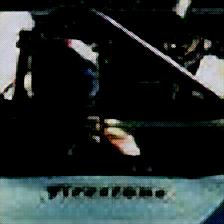

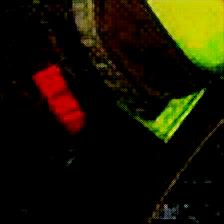

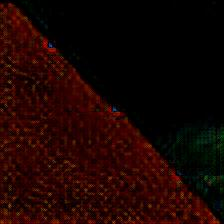

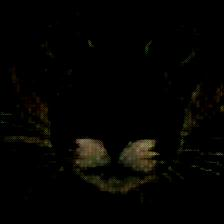

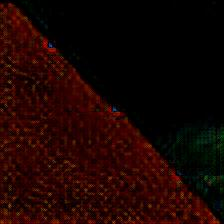

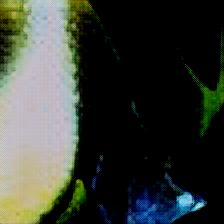

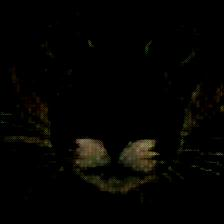

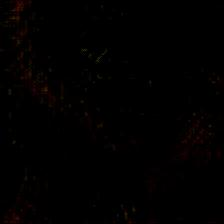

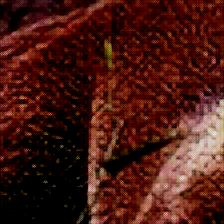

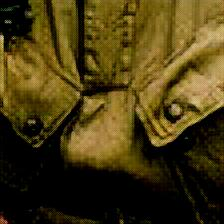

In [42]:
image_paths = [os.path.join(save_dir, img_name) for img_name in os.listdir(save_dir)]
idx = np.random.choice(len(image_paths), 10)
images = []
for i in idx:
    images.append(I(filename=image_paths[i]))

display(*images)